# **What brand is this laptop?**

Based on Lesson 2 of fast.ai's Deep Learning course, it is possible to scrape images of the internet (particularly Google Images) to build our own classifier, which is actually extremely useful and can be applied to any number of applications. 

Here, I chose a really simple problem, to classify laptops based on their brands using images of them. Although it may not seem so simple, since all laptops look similar to a certain extent, the highly efficient Deep Learning models will beg to differ.

This model gets around **83% accuracy**, which is a very good result considering how similar laptops from different brands look.

This is the code used to carry out this task:





In [0]:
from fastai.vision import *

After going on Google Images, and searching for whatever images we want (e.g Macbooks), we can insert a simple Javascript command into the browser:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```



Next, we create the necessary folder and file name for the data to be imported into.

I am using Google's Colab so all the images will be stored in Google Drive, from which the images are easily accesible.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
folder = 'macbook'
file = 'macbook.txt'

In [0]:
folder = 'hp'
file = 'hp.txt'

In [0]:
folder = 'lenovo'
file = 'lenovo.txt'

Code has to be run once for every category.

In [0]:
path = Path(base_dir+'/data/images')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [6]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/macbook.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/macbook'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/lenovo.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/hp'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/hp.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/lenovo'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/models'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/cleaned.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/export.pkl'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/images/mactest.jpg')]

Next, the files (txt files with urls of images) has to be uploaded into Drive.

Once that is done, the images can be downloaded into Drive, into the specified folders, from the urls using the download_images function.

In [0]:
download_images(path/file, dest, max_pics=200)

In [0]:
classes = ['macbook','hp','lenovo']

We can remove any images that cannot be opened:

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

Next, we can extract the images from the folders, and seperate them into training and validation sets, using the ImageDataBunch function.

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:534: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
images
  if getattr(ds, 'warn', False): warn(ds.warn)


Looking at some of the pictures:

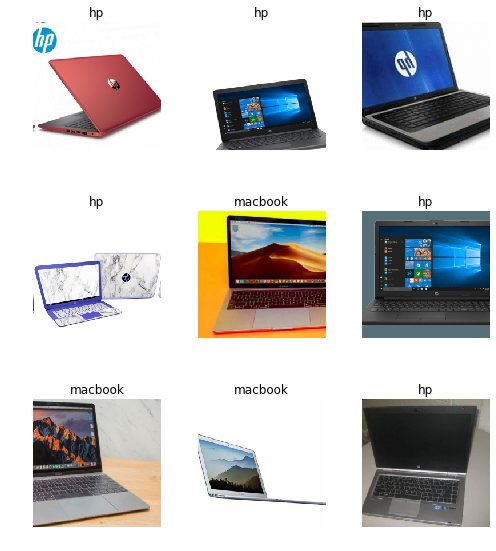

In [10]:
data.show_batch(rows=3, figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['hp', 'lenovo', 'macbook'], 3, 306, 75)

Training the model, using the cnn_learner function:

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 162957184.69it/s]


In [13]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.305020,0.848843,0.346667,00:54
1,1.121091,0.731948,0.293333,00:06
2,0.956481,0.663035,0.293333,00:05
3,0.809013,0.651194,0.266667,00:05
4,0.718085,0.661706,0.240000,00:05


In [14]:
learn.lr_find(start_lr=1e-5, end_lr=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Interpreting the results:

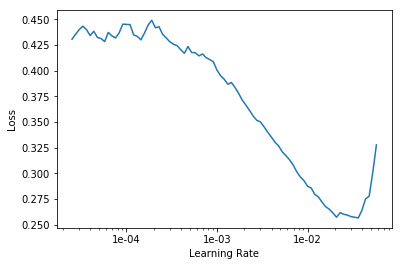

In [15]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(2,max_lr=slice(1e-03,1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,0.152411,0.790561,0.173333,00:05
1,0.102961,0.861176,0.186667,00:05


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

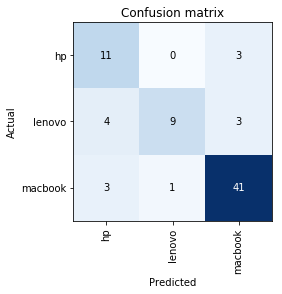

In [20]:
interp.plot_confusion_matrix()

In [21]:
interp.most_confused(min_val=2)

[('lenovo', 'hp', 4),
 ('hp', 'macbook', 3),
 ('lenovo', 'macbook', 3),
 ('macbook', 'hp', 3)]

Lenovo's are being mistaken for HP's 4 times, but the reverse doesn't seem to happen. Macbooks are the ones that are creating most of the error. 

Using an unused picture, and checking if our model can predict what laptop brand it is:



In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

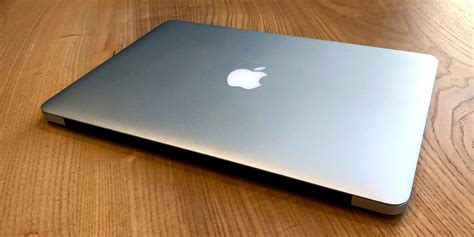

In [30]:
img = open_image(path/'mactest.jpg')
img

In [0]:
learn = load_learner(path)

In [27]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category macbook

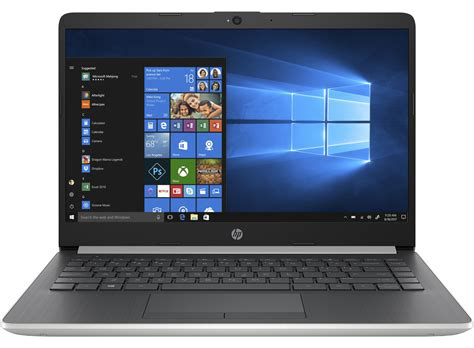

In [29]:
img1  = open_image(path/'hptest.jpg')
img1

In [33]:
pred_class,pred_idx,outputs = learn.predict(img1)
pred_class

Category hp

The model is able to predict these new images perfectly as well. 

A very simple application to do something pretty complex. 